In [1]:
import os
import pandas as pd
import nltk
import requests
import string
from gensim.models import Word2Vec, KeyedVectors
import shutil
import numpy as np
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Attention, Concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import shap


In [12]:
FINE_TUNED_DIR = '../../pretained_or_finetune-models'
REVIEWS_DATASET_DIR = '../../dataset'
UTILS_DIR = '../../utils'
NLTK_DATA_PATH = f"{FINE_TUNED_DIR}/nltk_data"

nltk.data.path.append(NLTK_DATA_PATH)

In [3]:
tourism_reviews_en = pd.read_csv(f"{REVIEWS_DATASET_DIR}/eng_reviews_emotion_classify.csv", encoding='utf-8')

columns_to_use = ['helpful_votes', 'location_id', 'review_id', 'review',
                  'review_subject', 'trip_type', 'rating',
                  'location_name', 'province', 'place_id', 'emotion', 'cleaned_review']
columns_to_train = ['location_id', 'review', 'rating']
review_df = tourism_reviews_en[columns_to_train]

In [4]:
review_df.describe()

,location_id,rating
count,5.909000e+03,5909.000000
mean,6.483167e+06,4.153833
std,4.877561e+06,1.067077
min,3.110380e+05,1.000000
25%,2.578107e+06,4.000000
50%,6.017599e+06,4.000000
75%,8.818088e+06,5.000000
max,2.714283e+07,5.000000


In [5]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5909 entries, 0 to 5908
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   location_id  5909 non-null   int64 
 1   review       5909 non-null   object
 2   rating       5909 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 138.6+ KB


In [97]:
review_df

,location_id,review,rating,cleaned_review,embedding,sentiment
0,2209612,Besides elegant grand palace and wat pra kaew ...,5,besides elegant grand palace wat pra kaew emer...,"[[-0.028509778901934624, 0.3325634002685547, 0...",positive
1,2209612,This is one of the last big king temples of Ba...,4,one last big king temple bangkok one lot europ...,"[[-0.003996930085122585, 0.014730370603501797,...",positive
2,2209612,"It is beautiful, clean and free to enter. Both...",4,beautiful clean free enter exterior interior s...,"[[-0.028509778901934624, 0.3325634002685547, 0...",positive
3,2209612,Wat Ratchabophit is a Buddhist temple located ...,5,wat ratchabophit buddhist temple located fuean...,"[[-0.0015841611893847585, 0.034438904374837875...",positive
4,2209612,Wat Ratchabophit is a historic royal temple bu...,5,wat ratchabophit historic royal temple built k...,"[[-0.0015841611893847585, 0.034438904374837875...",positive
...,...,...,...,...,...,...
5904,1831068,Is quite far from Korat Town or main highway. ...,3,quite far korat town main highway beautiful bu...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",neutral
5905,1831068,Prasat Pueai Noi is claimed to be the biggest ...,3,prasat pueai noi claimed biggest khmer sanctua...,"[[-0.004209618084132671, 0.07795886695384979, ...",neutral
5906,1831068,I think this place is claimed to be the oldest...,4,think place claimed oldest khmerstyle ruin upp...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive
5907,1831068,The compound comprises three brick buildings o...,4,compound comprises three brick building lateri...,"[[-0.020202770829200745, 0.1382008045911789, 0...",positive


In [15]:
binary_url = 'https://github.com/BrownDSI/word2vec-slim/releases/' + \
             'download/v0.1/GoogleNews-vectors-negative300-slim.bin.gz'
r = requests.get(binary_url)
open('google-word2vec-slim.bin.gz', 'wb').write(r.content);

#Load model contrained abot 300k of vocabs
model = KeyedVectors.load_word2vec_format('google-word2vec-slim.bin.gz', binary = True)

In [6]:
print(os.path.exists(f"{NLTK_DATA_PATH}/tokenizers/punkt")) 

True


In [ ]:
# 1. Data Preparation
nltk.download ('all', download_dir=NLTK_DATA_PATH)

In [18]:
from nltk.tokenize import word_tokenize, sent_tokenize
text = "Hello Mr. Smith, how are you doing today? The weather is great and Python is awesome. The sky is pinkish-blue. You should not eat cardboard."
word_tokenize ( text )
sent_tokenize ( text )

['Hello Mr. Smith, how are you doing today?',
 'The weather is great and Python is awesome.',
 'The sky is pinkish-blue.',
 'You should not eat cardboard.']

In [19]:
from nltk.corpus import stopwords

custom_stopwords = set(stopwords.words('english'))

In [9]:
print(nltk.data.find('tokenizers/punkt'))

/Users/ittichaiboonyarakthunya/nltk_data/tokenizers/punkt


In [10]:
from nltk.stem import WordNetLemmatizer

stop_words = custom_stopwords
lemmatizer = WordNetLemmatizer()

In [64]:
def advanced_clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters
    text = re.sub(r'\b(u|ur|b4)\b', 'you', text)  # Replace common abbreviations
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    words = [word for word in words if word not in string.punctuation]
    return ' '.join(words)

In [70]:
# Apply preprocessing to the review texts
review_df['cleaned_review'] = review_df['review'].apply(advanced_clean_text)

# 2. สร้าง Word Embeddings ด้วย Word2Vec
# word2vec_model = Word2Vec(sentences=review_df['cleaned_review'], vector_size=300, window=5, min_count=1, sg=1)  # ใช้ Skip-Gram
sentences = [row.split() for row in review_df['cleaned_review']]
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)  # เปลี่ยน vector_size เป็น 300



/var/folders/fk/449tdf_12hzd2r7ps4659q0m0000gn/T/ipykernel_14225/2616607316.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['cleaned_review'] = review_df['review'].apply(advanced_clean_text)


In [98]:
review_df.to_csv("./review_df.csv")
review_df

,location_id,review,rating,cleaned_review,embedding,sentiment
0,2209612,Besides elegant grand palace and wat pra kaew ...,5,besides elegant grand palace wat pra kaew emer...,"[[-0.028509778901934624, 0.3325634002685547, 0...",positive
1,2209612,This is one of the last big king temples of Ba...,4,one last big king temple bangkok one lot europ...,"[[-0.003996930085122585, 0.014730370603501797,...",positive
2,2209612,"It is beautiful, clean and free to enter. Both...",4,beautiful clean free enter exterior interior s...,"[[-0.028509778901934624, 0.3325634002685547, 0...",positive
3,2209612,Wat Ratchabophit is a Buddhist temple located ...,5,wat ratchabophit buddhist temple located fuean...,"[[-0.0015841611893847585, 0.034438904374837875...",positive
4,2209612,Wat Ratchabophit is a historic royal temple bu...,5,wat ratchabophit historic royal temple built k...,"[[-0.0015841611893847585, 0.034438904374837875...",positive
...,...,...,...,...,...,...
5904,1831068,Is quite far from Korat Town or main highway. ...,3,quite far korat town main highway beautiful bu...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",neutral
5905,1831068,Prasat Pueai Noi is claimed to be the biggest ...,3,prasat pueai noi claimed biggest khmer sanctua...,"[[-0.004209618084132671, 0.07795886695384979, ...",neutral
5906,1831068,I think this place is claimed to be the oldest...,4,think place claimed oldest khmerstyle ruin upp...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive
5907,1831068,The compound comprises three brick buildings o...,4,compound comprises three brick building lateri...,"[[-0.020202770829200745, 0.1382008045911789, 0...",positive


In [76]:
# Parameters
embedding_dim = 300  # Assuming Word2Vec has 300 dimensions
gru_units = 128
dropout_rate = 0.5
num_classes = 1  # Binary classification
max_sequence_length = 100  # Maximum length of input sequences
ngram_range = (1, 2)  # Unigrams and bigrams
max_features = 20000  

# Create the embedding matrix from the Word2Vec model
word_index = {word: i for i, word in enumerate(word2vec_model.wv.index_to_key)}
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

In [77]:
def text_to_word2vec(tokens, model, max_length=300):
    vector = np.zeros((max_length, 300))
    for i, word in enumerate(tokens):
        if i < max_length:
            if word in model.wv:
                vector[i] = model.wv[word]
    return vector

review_df['embedding'] = review_df['cleaned_review'].apply(lambda x: text_to_word2vec(x, word2vec_model))


/var/folders/fk/449tdf_12hzd2r7ps4659q0m0000gn/T/ipykernel_14225/1367629667.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['embedding'] = review_df['cleaned_review'].apply(lambda x: text_to_word2vec(x, word2vec_model))


In [78]:
def map_rating_to_sentiment(rating):
    if rating in [1, 2]:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:  # 4 or 5
        return 'positive'

review_df['sentiment'] = review_df['rating'].apply(map_rating_to_sentiment)

/var/folders/fk/449tdf_12hzd2r7ps4659q0m0000gn/T/ipykernel_14225/1027385966.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['sentiment'] = review_df['rating'].apply(map_rating_to_sentiment)


In [79]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(review_df['cleaned_review'])

X = tokenizer.texts_to_sequences(review_df['cleaned_review'])
X = pad_sequences(X, maxlen=max_sequence_length)

# แปลงคอลัมน์ 'sentiment' เป็นข้อมูลตัวเลข
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
y = review_df['sentiment'].map(label_mapping)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training+validation set into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


In [81]:
# Check the shapes of the resulting arrays
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (4727, 100)
y_train shape: (4727,)
X_test shape: (1182, 100)
y_test shape: (1182,)


In [82]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Step 6: Build the GRU Model
gru_units = 128
dropout_rate = 0.5
input_shape = X_train.shape[1:] 

model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_sequence_length,
                    trainable=False))
model.add(GRU(units=gru_units, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(GRU(units=gru_units))
model.add(Dropout(dropout_rate))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=3, activation='softmax'))   # 3 classes: negative, neutral, positive



/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if i < max_features:
        embedding_vector = word2vec_model.wv.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

AttributeError: 'KeyedVectors' object has no attribute 'get'

In [83]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [51]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5909 entries, 0 to 5908
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   location_id     5909 non-null   int64 
 1   review          5909 non-null   object
 2   rating          5909 non-null   int64 
 3   cleaned_review  5909 non-null   object
 4   embedding       5909 non-null   object
 5   sentiment       5909 non-null   object
dtypes: int64(2), object(4)
memory usage: 277.1+ KB


In [84]:
# Step 8: Train the Model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(X_test, y_test))


Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.7442 - loss: 1.0816 - val_accuracy: 0.7902 - val_loss: 1.0340
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - accuracy: 0.7966 - loss: 1.0185 - val_accuracy: 0.7902 - val_loss: 0.9775
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.7859 - loss: 0.9656 - val_accuracy: 0.7902 - val_loss: 0.9271
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.7859 - loss: 0.9177 - val_accuracy: 0.7902 - val_loss: 0.8835
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.8014 - loss: 0.8670 - val_accuracy: 0.7902 - val_loss: 0.8454
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.7943 - loss: 0.8343 - val_accuracy: 0.7902 - val_loss: 0.8132
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.7904 - loss: 0.8060 - val_accuracy: 0.7902 - val_loss: 0.7857
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.7994 - loss: 0.7712 - val_accuracy: 

In [85]:
# 1. Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# 2. Make Predictions
y_pred_prob = model.predict(X_test)

# If your output layer is using 'softmax', y_pred_prob will be probabilities for each class.
# To get the predicted class labels, you can use np.argmax:
y_pred_class = np.argmax(y_pred_prob, axis=1)

# 3. Compare the predicted labels with the true labels
print(f'Predicted classes: {y_pred_class[:10]}')  # Display the first 10 predictions
print(f'True classes: {y_test[:10]}')  

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7888 - loss: 0.7281
Test Loss: 0.7265
Test Accuracy: 0.7902
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Predicted classes: [2 2 2 2 2 2 2 2 2 2]
True classes: 3489    0
4909    2
1425    2
4743    1
439     2
5490    2
1319    2
1330    2
4091    2
296     2
Name: sentiment, dtype: int64


In [96]:
X_test

array([[    0,     0,     0, ...,    51,   706,     4],
       [    0,     0,     0, ..., 14692,  5535,    69],
       [    0,     0,     0, ..., 10124,  5800,   610],
       ...,
       [    0,     0,     0, ...,  1080,  5570,   633],
       [    0,     0,     0, ...,   476,   101,   173],
       [    0,     0,     0, ...,  1387,   283,   344]], dtype=int32)

In [91]:
y_pred_prob

array([[0.18715638, 0.19472776, 0.6181158 ],
       [0.18715638, 0.19472776, 0.6181158 ],
       [0.18715638, 0.19472776, 0.6181158 ],
       ...,
       [0.18715638, 0.19472776, 0.6181158 ],
       [0.1871564 , 0.19472778, 0.61811584],
       [0.1871564 , 0.19472778, 0.61811584]], dtype=float32)

In [95]:
y_test

3489    0
4909    2
1425    2
4743    1
439     2
       ..
5333    2
4310    2
653     2
429     1
1773    2
Name: sentiment, Length: 1182, dtype: int64

In [ ]:
review_df['sentiment'] = review_df['rating'].apply(map_rating_to_sentiment)

In [89]:
# Creating a new DataFrame for the test set
test_df = pd.DataFrame({
    'review_text': review_df.loc[X_test.index, 'review'],  # Assuming X_test is a subset with a specific index
    'actual_sentiment': y_test,  # The actual sentiment labels
    'predicted_sentiment': y_pred_class  # The predicted sentiment labels
})

# Step 3: (Optional) Map integer labels to their sentiment names
label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
test_df['actual_sentiment'] = test_df['actual_sentiment'].map(label_mapping)
test_df['predicted_sentiment'] = test_df['predicted_sentiment'].map(label_mapping)

# Display the first few rows of the resulting DataFrame
print(test_df.head())


AttributeError: 'numpy.ndarray' object has no attribute 'index'

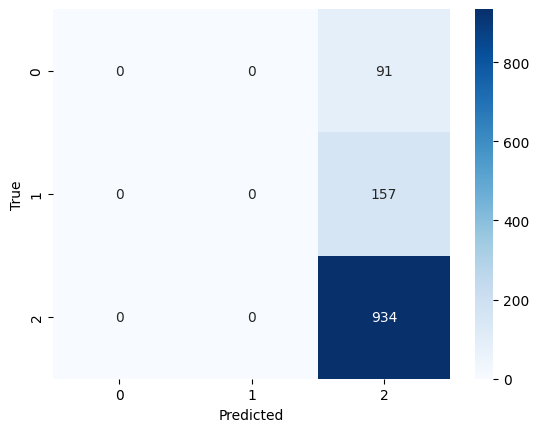

In [86]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [87]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_class, target_names=['negative', 'neutral', 'positive']))


              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        91
     neutral       0.00      0.00      0.00       157
    positive       0.79      1.00      0.88       934

    accuracy                           0.79      1182
   macro avg       0.26      0.33      0.29      1182
weighted avg       0.62      0.79      0.70      1182



/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python